In [1]:
!pip install --upgrade jax==0.5.1 jaxlib==0.5.1
!pip install jaxkan diffrax

In [2]:
import jax
import jaxlib
import jax.numpy as jnp
import diffrax
import numpy as np
import matplotlib.pyplot as plt
from jaxkan.KAN import KAN
from flax import nnx
import optax
import time

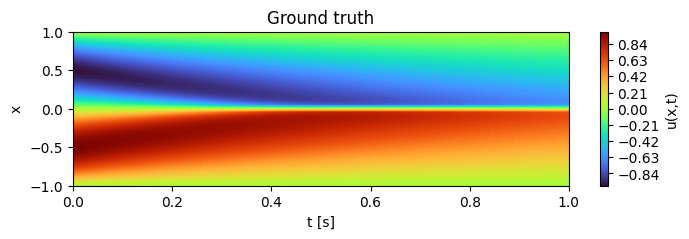

In [3]:
# Ground Truth:

x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0

dx = 0.05
dt = 0.01

xgrid = jnp.arange(x_min, x_max + dx, dx)
tgrid = jnp.arange(t_min, t_max + dt, dt)

u0 = - jnp.sin(jnp.pi * xgrid)

def vector_field(t, u, args):

    dx = args

    dudx = (u - jnp.roll(u, 1)) / dx * (u > 0) + (jnp.roll(u, -1) - u) / dx * (u < 0)
    d2udx2 = (jnp.roll(u, -1) - 2 * u + jnp.roll(u, 1)) / dx**2

    du_dt = -u * dudx + (0.01 / jnp.pi) * d2udx2

    du_dt = du_dt.at[0].set(0)
    du_dt = du_dt.at[-1].set(0)

    return du_dt

solver = diffrax.Tsit5()

stepsize_controller = diffrax.PIDController(rtol = 1e-4, atol = 1e-6)
term = diffrax.ODETerm(vector_field)
saveat = diffrax.SaveAt(ts = tgrid)

solution = diffrax.diffeqsolve(term, solver, t0 = t_min, t1 = t_max, dt0 = dt, y0 = u0, args = dx, saveat = saveat, stepsize_controller = stepsize_controller)

U = jnp.array(solution.ys).T

plt.figure(figsize = (8, 2))
plt.contourf(tgrid, xgrid, U, levels = 201, cmap = "turbo")
plt.colorbar(label = "u(x,t)")
plt.xlabel("t [s]")
plt.ylabel("x")
plt.title("Ground truth")
plt.show()

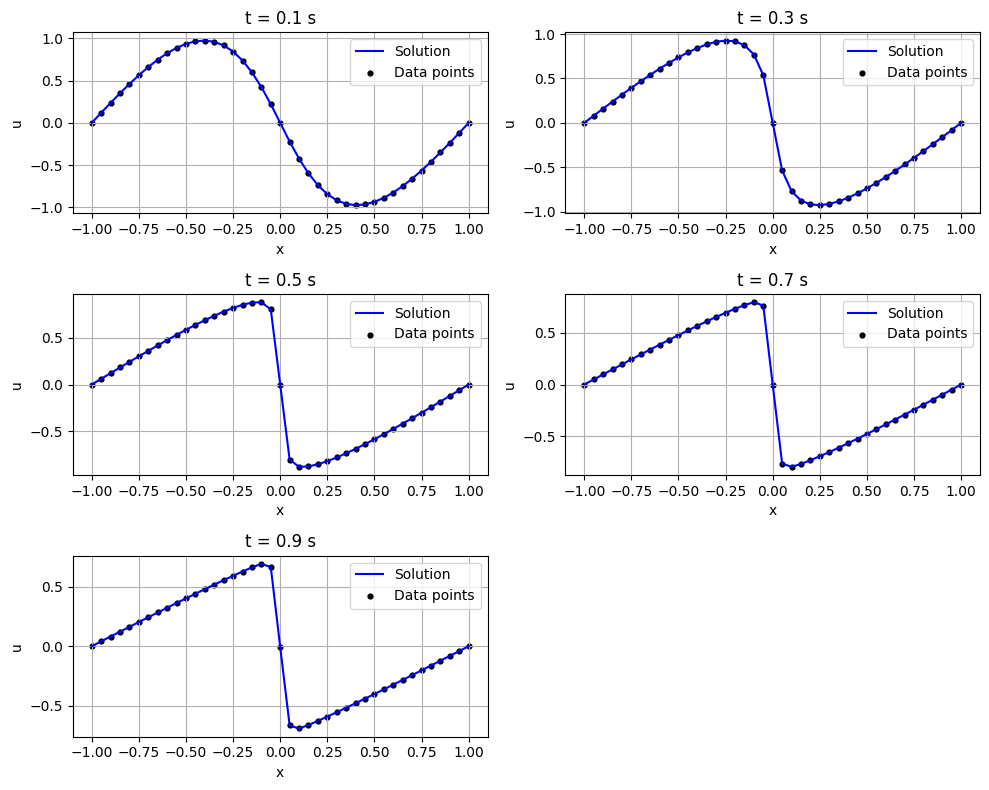

In [4]:
# Training and test data:

t_train = jnp.array([0.1, 0.3, 0.5, 0.7, 0.9])
t_test = jnp.array([0.2, 0.4, 0.6, 0.8, 1.0])

train_data = jnp.zeros((len(t_train), len(xgrid)))
test_data = jnp.zeros((len(t_test), len(xgrid)))

for i, t in enumerate(t_train):
    idx = jnp.abs(tgrid - t).argmin()
    train_data = train_data.at[i, :].set(U[:, idx])

for i, t in enumerate(t_test):
    idx = jnp.abs(tgrid - t).argmin()
    test_data = test_data.at[i, :].set(U[:, idx])

# Plotting training data:

plt.figure(figsize = (10, 8))

for i, t in enumerate(t_train):

    plt.subplot(3, 2, i + 1)
    plt.plot(xgrid, train_data[i,:], label = "Solution", color = "b")
    plt.scatter(xgrid, train_data[i,:], color = "black", s = 12, label = "Data points")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.title(f"t = {t:.1f} s")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [5]:
# Model definitions:

class dF(nnx.Module):

    def __init__(self, dy_dt):
        self.dy_dt = dy_dt
    def __call__(self, t, y, args):
        y = y[jnp.newaxis, :]
        return self.dy_dt(y)[0]

class NODE(nnx.Module):

    def __init__(self,dF):
        self.dF = dF

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.dF),
            diffrax.Tsit5(),
            t0 = t_min,
            t1 = t_max,
            dt0 = dt,
            y0 = y0,
            stepsize_controller = diffrax.PIDController(rtol = 1e-4, atol = 1e-6),
            saveat = diffrax.SaveAt(ts = ts),
        )
        return solution.ys

In [6]:
# Loss function:

def loss_fn(model, t, u_0, u_true):
    u_pred = model(t, u_0)
    return jnp.mean((u_pred - u_true) ** 2)

# Optimizer:

opt_type = optax.adam(learning_rate = 0.001)

In [7]:
# L2 relative error:

def l2_relative_error(y_pred, y_true):
    numerator = jnp.linalg.norm(y_pred - y_true)
    denominator = jnp.linalg.norm(y_true)
    return numerator / denominator

In [8]:
# Training step:

@nnx.jit
def train_step(model, optimizer, t_train, u0_train, u_train):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, u0_train, u_train)
    optimizer.update(grads)

    return train_loss

# Test step:

@nnx.jit
def test_step(model, optimizer, t_train, u0_train, u_train, t_test, u_test, tgrid, U):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, u0_train, u_train)
    optimizer.update(grads)
    test_loss = loss_fn(model, t_test, u0_train, u_test)
    l2_error = l2_relative_error(model(tgrid, u0_train), U)

    return train_loss, test_loss, l2_error

In [9]:
# Training function:

def train(model, optimizer, num_epochs):

    train_losses = jnp.zeros(num_epochs)
    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss = train_step(model, optimizer, t_train, u0, train_data)
        train_losses = train_losses.at[epoch].set(train_loss)

    print(f"Training time: {(time.time() - start_time)/num_epochs:.3f} seconds")

    return train_losses

# Test function:

def test(model, optimizer, num_epochs):

    train_losses = jnp.zeros(num_epochs)
    test_losses = jnp.zeros(num_epochs)
    l2_errors = jnp.zeros(num_epochs)

    for epoch in range(num_epochs):
        train_loss, test_loss, l2_error = test_step(model, optimizer, t_train, u0, train_data, t_test, test_data, tgrid, U.T)
        train_losses = train_losses.at[epoch].set(train_loss)
        test_losses = test_losses.at[epoch].set(test_loss)
        l2_errors = l2_errors.at[epoch].set(l2_error)

    return train_losses, test_losses, l2_errors

In [10]:
num_epochs = 10000

In [11]:
# KAN-ODE-spline training:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'spline',
            required_parameters = {'G': 5}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_spline = train(KANODE_model, optimizer, num_epochs)

Training time: 0.025 seconds


In [12]:
# KAN-ODE-spline test:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'spline',
            required_parameters = {'G': 5}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_spline, test_losses_spline, l2_errors_spline = test(KANODE_model, optimizer, num_epochs)

In [13]:
# KAN-ODE-chebyshev training:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'chebyshev',
            required_parameters = {'D': 8, 'flavor': 'exact', 'external_weights': True, 'residual':nnx.silu}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_chebyshev = train(KANODE_model, optimizer, num_epochs)

Training time: 0.037 seconds


In [14]:
# KAN-ODE-chebyshev test:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'chebyshev',
            required_parameters = {'D': 8, 'flavor': 'exact', 'external_weights': True, 'residual':nnx.silu}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_chebyshev, test_losses_chebyshev, l2_errors_chebyshev = test(KANODE_model, optimizer, num_epochs)

In [15]:
# KAN-ODE-legendre training:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'legendre',
            required_parameters = {'D': 8, 'flavor' : 'exact', 'external_weights' : True, 'residual' : nnx.silu},
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_legendre = train(KANODE_model, optimizer, num_epochs)

Training time: 0.027 seconds


In [16]:
# KAN-ODE-legendre test:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'legendre',
            required_parameters = {'D': 8, 'flavor' : 'exact', 'external_weights' : True, 'residual' : nnx.silu},
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_legendre, test_losses_legendre, l2_errors_legendre = test(KANODE_model, optimizer, num_epochs)

In [17]:
# KAN-ODE-rbf training:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'rbf',
            required_parameters = {'D': 8, 'external_weights' : True, 'residual' : nnx.silu, 'kernel' : {'type': 'gaussian'}}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_rbf = train(KANODE_model, optimizer, num_epochs)

Training time: 0.013 seconds


In [18]:
# KAN-ODE-rbf test:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'rbf',
            required_parameters = {'D': 8, 'external_weights' : True, 'residual' : nnx.silu, 'kernel' : {'type': 'gaussian'}}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_rbf, test_losses_rbf, l2_errors_rbf = test(KANODE_model, optimizer, num_epochs)

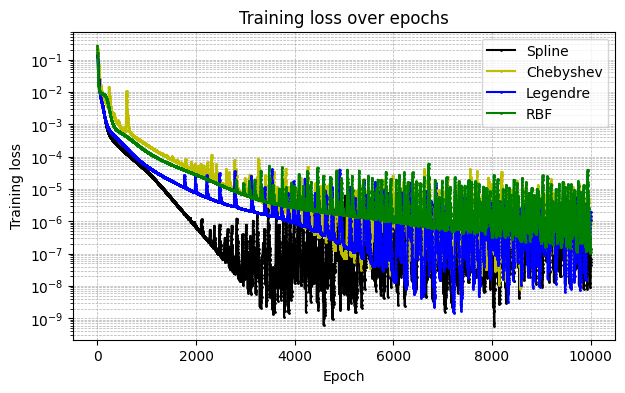

In [23]:
# Training loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(train_losses_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(train_losses_chebyshev), label = 'Chebyshev', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(train_losses_legendre), label = 'Legendre', marker = 'o', color = 'b', markersize = 1)
plt.plot(np.array(train_losses_rbf), label = 'RBF', marker = 'o', color = 'g', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [24]:
# Final training losses:

print(f"Final training loss for the 'spline' KAN-ODE : {train_losses_spline[-1]:.8f}")
print(f"Final training loss for the 'chebyshev' KAN-ODE:  {train_losses_chebyshev[-1]:.8f}")
print(f"Final training loss for the 'legendre' KAN-ODE:  {train_losses_legendre[-1]:.8f}")
print(f"Final training loss for the 'rbf' KAN-ODE:  {train_losses_rbf[-1]:.8f}")

Final training loss for the 'spline' KAN-ODE : 0.00000007
Final training loss for the 'chebyshev' KAN-ODE:  0.00000125
Final training loss for the 'legendre' KAN-ODE:  0.00000190
Final training loss for the 'rbf' KAN-ODE:  0.00000014


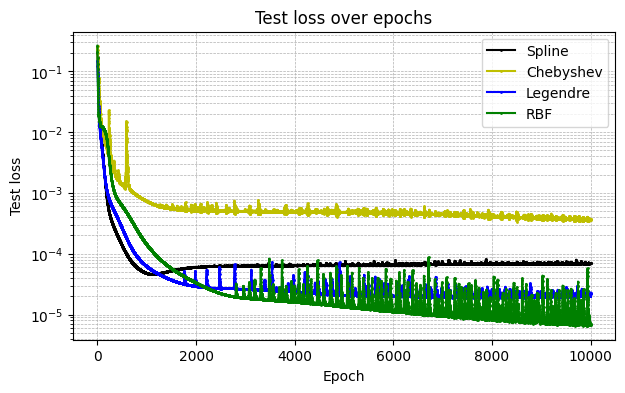

In [25]:
# Test loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(test_losses_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(test_losses_chebyshev), label = 'Chebyshev', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(test_losses_legendre), label = 'Legendre', marker = 'o', color = 'b', markersize = 1)
plt.plot(np.array(test_losses_rbf), label = 'RBF', marker = 'o', color = 'g', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [26]:
# Final test losses:

print(f"Final test loss for the 'spline' KAN-ODE : {test_losses_spline[-1]:.6f}")
print(f"Final test loss for the 'chebyshev' KAN-ODE:  {test_losses_chebyshev[-1]:.6f}")
print(f"Final test loss for the 'legendre' KAN-ODE:  {test_losses_legendre[-1]:.6f}")
print(f"Final test loss for the 'rbf' KAN-ODE:  {test_losses_rbf[-1]:.6f}")

Final test loss for the 'spline' KAN-ODE : 0.000070
Final test loss for the 'chebyshev' KAN-ODE:  0.000373
Final test loss for the 'legendre' KAN-ODE:  0.000023
Final test loss for the 'rbf' KAN-ODE:  0.000007


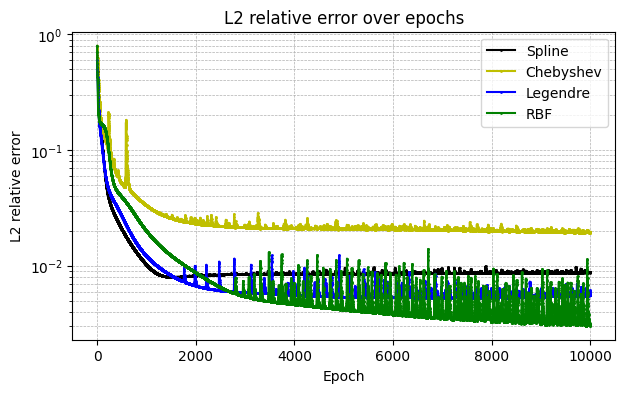

In [27]:
# L2 relative error:

plt.figure(figsize = (7, 4))

plt.plot(np.array(l2_errors_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(l2_errors_chebyshev), label = 'Chebyshev', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(l2_errors_legendre), label = 'Legendre', marker = 'o', color = 'b', markersize = 1)
plt.plot(np.array(l2_errors_rbf), label = 'RBF', marker = 'o', color = 'g', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('L2 relative error')
plt.title('L2 relative error over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [29]:
# Final L2 relative errors:

print(f"Final L2 relative error for the 'spline' KAN-ODE : {l2_errors_spline[-1]:.4f}")
print(f"Final L2 relative error for the 'chebyshev' KAN-ODE:  {l2_errors_chebyshev[-1]:.4f}")
print(f"Final L2 relative error for the 'legendre' KAN-ODE:  {l2_errors_legendre[-1]:.4f}")
print(f"Final L2 relative error for the 'rbf' KAN-ODE:  {l2_errors_rbf[-1]:.4f}")

Final L2 relative error for the 'spline' KAN-ODE : 0.0088
Final L2 relative error for the 'chebyshev' KAN-ODE:  0.0197
Final L2 relative error for the 'legendre' KAN-ODE:  0.0061
Final L2 relative error for the 'rbf' KAN-ODE:  0.0031


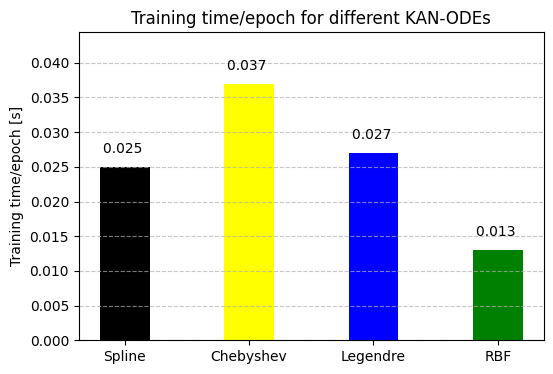

In [30]:
# Training time/epoch:

models = ["Spline", "Chebyshev", "Legendre", 'RBF']
training_times = [0.025, 0.037, 0.027, 0.013]

plt.figure(figsize=(6, 4))
plt.bar(models, training_times, color=['black', 'yellow', 'blue', 'green'], width = 0.4)


plt.ylabel("Training time/epoch [s]")
plt.title("Training time/epoch for different KAN-ODEs")
plt.ylim(0, max(training_times) * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, time in enumerate(training_times):
    plt.text(i, time + 0.002, f"{time:.3f} ", ha="center", fontsize=10)

plt.show()

In [37]:
# Experiments (training times ~ 270 s):

In [32]:
# KAN-ODE-legendre test:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'legendre',
            required_parameters = {'D': 8, 'flavor' : 'exact', 'external_weights' : True, 'residual' : nnx.silu},
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_legendre, test_losses_legendre, l2_errors_legendre = test(KANODE_model, optimizer, num_epochs)

In [34]:
# KAN-ODE-spline test:

KAN_model = KAN(
            layer_dims = [41, 10, 41],
            layer_type = 'spline',
            required_parameters = {'G': 5}
           )

num_epochs = 10800

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_spline, test_losses_spline, l2_errors_spline = test(KANODE_model, optimizer, num_epochs)

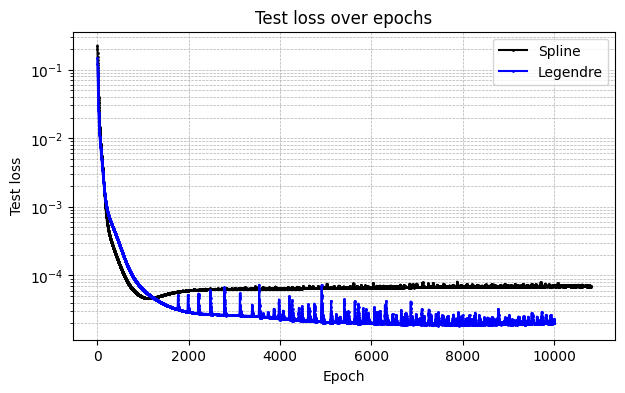

In [35]:
# Test loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(test_losses_spline), label = 'Spline', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(test_losses_legendre), label = 'Legendre', marker = 'o', color = 'b', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [36]:
# Final test losses:

print(f"Final test loss for the 'spline' KAN-ODE : {test_losses_spline[-1]:.6f}")
print(f"Final test loss for the 'legendre' KAN-ODE:  {test_losses_legendre[-1]:.6f}")

Final test loss for the 'spline' KAN-ODE : 0.000071
Final test loss for the 'legendre' KAN-ODE:  0.000023
